# **Dataset  CIFAR-10**

In [ ]:
import torchvision
import torchvision.transforms as transforms

data_dir = './data'


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, transform=transform, download=True)




100%|██████████| 170498071/170498071 [00:01<00:00, 98266641.18it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import numpy as np

noise_rate = 0.1

for dataset in [trainset, testset]:
    labels = dataset.targets
    num_samples = len(labels)
    num_corrupted_samples = int(noise_rate * num_samples)
    corrupted_indices = np.random.choice(num_samples, num_corrupted_samples, replace=False)

    for i in corrupted_indices:
        new_label = np.random.randint(0, 10)
        while new_label == labels[i]:
            new_label = np.random.randint(0, 10)
        labels[i] = new_label


In [ ]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # Add parentheses here
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


net = Net()


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("Finished Training")


correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


Epoch 1, Loss: 2.2677363791429173
Epoch 2, Loss: 2.0115373308396403
Epoch 3, Loss: 1.826540326828237
Epoch 4, Loss: 1.7166160270381157
Epoch 5, Loss: 1.6496102915090674
Epoch 6, Loss: 1.5975754350957359
Epoch 7, Loss: 1.551042206756904
Epoch 8, Loss: 1.5078179188396619
Epoch 9, Loss: 1.4660121569853
Epoch 10, Loss: 1.423891769345764
Finished Training
Accuracy on the test dataset: 53.07%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
train_loss_history = []
test_accuracy_history = []

class MentorNet(nn.Module):
    def __init__(self):
        super(MentorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



mentornet = MentorNet()


mentornet_criterion = nn.CrossEntropyLoss()


mentornet_optimizer = optim.SGD(mentornet.parameters(), lr=0.01, momentum=0.9)


mentornet.train()
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        mentornet_optimizer.zero_grad()
        outputs = mentornet(inputs)
        loss = mentornet_criterion(outputs, labels)
        loss.backward()
        mentornet_optimizer.step()
        running_loss += loss.item()
    print(f"MentorNet Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


mentornet.eval()
for param in mentornet.parameters():
    param.requires_grad = False


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



net = Net()


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)


        with torch.no_grad():
            mentor_outputs = mentornet(inputs)
            regularizer_loss = nn.functional.kl_div(nn.functional.log_softmax(outputs, dim=1),
                                                    nn.functional.softmax(mentor_outputs, dim=1), reduction='batchmean')

        loss = criterion(outputs, labels) + regularizer_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss = running_loss / len(trainloader)
        train_loss_history.append(train_loss)
    print(f"Main Model Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# Evaluate the main model
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


MentorNet Epoch 1, Loss: 1.809030694577395
MentorNet Epoch 2, Loss: 1.3761804860723599
MentorNet Epoch 3, Loss: 1.1473420988720702
MentorNet Epoch 4, Loss: 0.9954938681229301
MentorNet Epoch 5, Loss: 0.8869718002236407
MentorNet Epoch 6, Loss: 0.8098273214019472
MentorNet Epoch 7, Loss: 0.7583589325551792
MentorNet Epoch 8, Loss: 0.7109962046679938
MentorNet Epoch 9, Loss: 0.6715272122331898
MentorNet Epoch 10, Loss: 0.6361835056253712
Main Model Epoch 1, Loss: 2.9703412876104758
Main Model Epoch 2, Loss: 2.107454141082666
Main Model Epoch 3, Loss: 1.705667868447121
Main Model Epoch 4, Loss: 1.4298439666133402
Main Model Epoch 5, Loss: 1.2650479021889474
Main Model Epoch 6, Loss: 1.159488080864977
Main Model Epoch 7, Loss: 1.0832839410780641
Main Model Epoch 8, Loss: 1.031936168746875
Main Model Epoch 9, Loss: 0.9975734115256678
Main Model Epoch 10, Loss: 0.9658245881042822
Accuracy on the test dataset: 79.28%


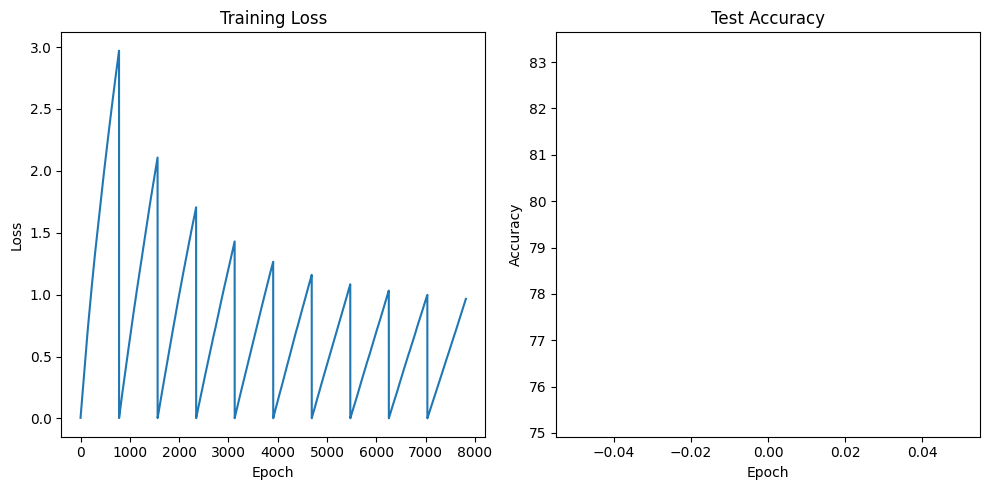

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracy_history)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [ ]:
import requests
import os
from tqdm import tqdm
from zipfile import ZipFile
import shutil


data_dir = '/content/tiny-imagenet-200'


dataset_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
download_path = os.path.join(data_dir, "tiny-imagenet-200.zip")

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(download_path):
    response = requests.get(dataset_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB

    with open(download_path, 'wb') as file, tqdm(
            desc=download_path,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            file.write(data)
            bar.update(len(data))


with ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)


train_dir = os.path.join(data_dir, "tiny-imagenet-200", "train")
val_dir = os.path.join(data_dir, "tiny-imagenet-200", "val")
test_dir = os.path.join(data_dir, "tiny-imagenet-200", "test")


print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {val_dir}")
print(f"Test Directory: {test_dir}")


/content/tiny-imagenet-200/tiny-imagenet-200.zip: 100%|██████████| 237M/237M [00:21<00:00, 11.5MB/s]


Train Directory: /content/tiny-imagenet-200/tiny-imagenet-200/train
Validation Directory: /content/tiny-imagenet-200/tiny-imagenet-200/val
Test Directory: /content/tiny-imagenet-200/tiny-imagenet-200/test


# **Dataset  Tiny-ImageNet**

In [ ]:
import os
import random

train_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/train'
val_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/val'

noise_rate = 0.1


def add_noisy_labels(dataset_dir, noise_rate):
    class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    noisy_to_original = {}

    for class_name in class_dirs:
        noisy_class = class_name
        original_class = random.choice(class_dirs)
        noisy_to_original[noisy_class] = original_class

    for noisy_class, original_class in noisy_to_original.items():
        noisy_class_path = os.path.join(dataset_dir, noisy_class)
        original_class_path = os.path.join(dataset_dir, original_class)

        if not os.path.exists(original_class_path):
            os.mkdir(original_class_path)

        image_files = os.listdir(noisy_class_path)
        num_images = len(image_files)
        num_noisy_labels = int(noise_rate * num_images)

        noisy_indices = random.sample(image_files, num_noisy_labels)

        for image_file in noisy_indices:
            noisy_image_path = os.path.join(noisy_class_path, image_file)
            original_image_path = os.path.join(original_class_path, image_file)
            os.rename(noisy_image_path, original_image_path)


add_noisy_labels(train_dir, noise_rate)


add_noisy_labels(val_dir, noise_rate)


In [ ]:
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = datasets.ImageFolder(root=train_dir, transform=transform)
valset = datasets.ImageFolder(root=val_dir, transform=transform)
testset = datasets.ImageFolder(root=test_dir, transform=transform)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np


num_classes = 200

# Define a simple CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = self.fc1(x)
        return x


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
model.train()
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


Epoch 1, Loss: 4.429145595009938
Epoch 2, Loss: 3.505362228788936
Epoch 3, Loss: 2.520577501121882
Epoch 4, Loss: 1.580799865440459
Epoch 5, Loss: 0.9909217026625698
Epoch 6, Loss: 0.6454692498059206
Epoch 7, Loss: 0.441671110565702
Epoch 8, Loss: 0.32927558205959817
Epoch 9, Loss: 0.23287915366434242
Epoch 10, Loss: 0.161956823362432
Accuracy on the test dataset: 0.34%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.functional import softmax, log_softmax, kl_div



trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 200)  # 200 classes in TinyImageNet

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

mentornet = SimpleCNN()


mentornet_criterion = nn.CrossEntropyLoss()


mentornet_optimizer = optim.SGD(mentornet.parameters(), lr=0.01, momentum=0.9)

mentornet.train()
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        mentornet_optimizer.zero_grad()
        outputs = mentornet(inputs)
        loss = mentornet_criterion(outputs, labels)
        loss.backward()
        mentornet_optimizer.step()
        running_loss += loss.item()
    print(f"MentorNet Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


mentornet.eval()
main_model = SimpleCNN()

main_model_criterion = nn.CrossEntropyLoss()


main_model_optimizer = optim.SGD(main_model.parameters(), lr=0.01, momentum=0.9)

main_model.train()
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        main_model_optimizer.zero_grad()
        main_outputs = main_model(inputs)


        with torch.no_grad():
            mentor_outputs = mentornet(inputs)
            pseudo_labels = torch.argmax(mentor_outputs, dim=1)


        regularizer_loss = kl_div(log_softmax(main_outputs, dim=1), softmax(mentor_outputs, dim=1), reduction='batchmean')

        loss = main_model_criterion(main_outputs, pseudo_labels) + regularizer_loss
        loss.backward()
        main_model_optimizer.step()
        running_loss += loss.item()
    print(f"Main Model Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# Evaluate the main model
main_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = main_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f"Main Model Test Accuracy: {test_accuracy:.2f}%")


MentorNet Epoch 1, Loss: 4.612491848982837
MentorNet Epoch 2, Loss: 3.733918127003802
MentorNet Epoch 3, Loss: 3.2638310690530203
MentorNet Epoch 4, Loss: 2.7759270565828604
MentorNet Epoch 5, Loss: 2.1512957061626024
MentorNet Epoch 6, Loss: 1.36022331206675
MentorNet Epoch 7, Loss: 0.6691438201064112
MentorNet Epoch 8, Loss: 0.3547170425187832
MentorNet Epoch 9, Loss: 0.22811140185573583
MentorNet Epoch 10, Loss: 0.17693116998994723
Main Model Epoch 1, Loss: 8.69943105663463
Main Model Epoch 2, Loss: 7.093697182428967
Main Model Epoch 3, Loss: 6.006301806969133
Main Model Epoch 4, Loss: 4.62298497448956
Main Model Epoch 5, Loss: 2.8116793157348097
Main Model Epoch 6, Loss: 1.3853297546477328
Main Model Epoch 7, Loss: 0.7228675152122097
Main Model Epoch 8, Loss: 0.42405130931069585
Main Model Epoch 9, Loss: 0.30047376310394425
Main Model Epoch 10, Loss: 0.24344127456957304
Main Model Test Accuracy: 0.44%


# **Dataset  CIFAR-100**

In [ ]:
import torchvision
import torchvision.transforms as transforms

#  the data directory
data_dir = './data'


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# the CIFAR-100 dataset if it doesn't exist
trainset = torchvision.datasets.CIFAR100(root=data_dir, train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR100(root=data_dir, train=False, transform=transform, download=True)




100%|██████████| 169001437/169001437 [00:02<00:00, 73455670.77it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import numpy as np

noise_rate = 0.1

for dataset in [trainset, testset]:
    labels = dataset.targets
    num_samples = len(labels)
    num_corrupted_samples = int(noise_rate * num_samples)
    corrupted_indices = np.random.choice(num_samples, num_corrupted_samples, replace=False)

    for i in corrupted_indices:
        new_label = np.random.randint(0, 100)  #  a random new label
        while new_label == labels[i]:
            new_label = np.random.randint(0, 100)
        labels[i] = new_label


In [ ]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

device

'cpu'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
labels = torch.tensor(labels).to(device=device)

In [ ]:
#  a data loader for training and testing
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
trainloader.batch_size, trainloader.batch_sampler, trainloader.dataset


(64,
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [ ]:
import time
# Instantiate the model
net = Net().to(device='cpu')


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
print('Starting Training')
for epoch in range(50):
    running_loss = 0.0
    start_time_for_one_epoch = time.time()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%5 == 0:
            tmp = (i/780)*100
            print(f'Status:{tmp:.3f}%',end='\r')
    end_time_for_one_epoch = time.time()
    elapsed_time = end_time_for_one_epoch - start_time_for_one_epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, and Time Taken {elapsed_time}")

print("Finished Training")

Starting Training
Epoch 1, Loss: 4.6016925789815994, and Time Taken 148.82223296165466
Epoch 2, Loss: 4.569537955476805, and Time Taken 137.7983317375183
Epoch 3, Loss: 4.340230880490959, and Time Taken 135.29752349853516
Epoch 4, Loss: 4.113423479182641, and Time Taken 136.37893724441528
Epoch 5, Loss: 3.978248520580399, and Time Taken 137.108008146286
Epoch 6, Loss: 3.858575509942096, and Time Taken 136.71646904945374
Epoch 7, Loss: 3.7511785353541067, and Time Taken 137.659033536911
Epoch 8, Loss: 3.6453512431410573, and Time Taken 136.49753642082214
Epoch 9, Loss: 3.5499361265650795, and Time Taken 136.0011157989502
Epoch 10, Loss: 3.4621514036222494, and Time Taken 137.16923260688782
Epoch 11, Loss: 3.383190925468874, and Time Taken 137.01190638542175
Epoch 12, Loss: 3.303810731834158, and Time Taken 136.19101905822754
Epoch 13, Loss: 3.2259631538025255, and Time Taken 138.03310441970825
Epoch 14, Loss: 3.155630347064084, and Time Taken 137.3212010860443
Epoch 15, Loss: 3.07758508

In [ ]:


# Evaluation on the test dataset
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


Accuracy on the test dataset: 27.70%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
train_loss_history = []
test_accuracy_history = []

class MentorNet(nn.Module):
    def __init__(self):
        super(MentorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



mentornet = MentorNet()


mentornet_criterion = nn.CrossEntropyLoss()

mentornet_optimizer = optim.SGD(mentornet.parameters(), lr=0.01, momentum=0.9)


mentornet.train()
for epoch in range(10):  # Train MentorNet for a few epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        mentornet_optimizer.zero_grad()
        outputs = mentornet(inputs)
        loss = mentornet_criterion(outputs, labels)
        loss.backward()
        mentornet_optimizer.step()
        running_loss += loss.item()
    print(f"MentorNet Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

# the MentorNet for fine-tuning
mentornet.eval()
for param in mentornet.parameters():
    param.requires_grad = False


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()


criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Training loop for the main model
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)

        # Using MentorNet to regularize the training
        with torch.no_grad():
            mentor_outputs = mentornet(inputs)
            regularizer_loss = nn.functional.kl_div(nn.functional.log_softmax(outputs, dim=1),
                                                    nn.functional.softmax(mentor_outputs, dim=1), reduction='batchmean')

        loss = criterion(outputs, labels) + regularizer_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loss = running_loss / len(trainloader)
        train_loss_history.append(train_loss)
    print(f"Main Model Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

#  the main model
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
print(f"Accuracy on the test dataset: {100 * correct / total:.2f}%")


MentorNet Epoch 1, Loss: 4.303628676382782
MentorNet Epoch 2, Loss: 3.701382056831399
MentorNet Epoch 3, Loss: 3.3297152845450984
MentorNet Epoch 4, Loss: 3.0369825997316013
MentorNet Epoch 5, Loss: 2.786003841158679
MentorNet Epoch 6, Loss: 2.5515648715026544
MentorNet Epoch 7, Loss: 2.3113792316078223
MentorNet Epoch 8, Loss: 2.0631209967081503
MentorNet Epoch 9, Loss: 1.7984884121381413
MentorNet Epoch 10, Loss: 1.5032132689452842
Main Model Epoch 1, Loss: 7.075976869334346
Main Model Epoch 2, Loss: 5.896189776832795
Main Model Epoch 3, Loss: 5.17989335035729
Main Model Epoch 4, Loss: 4.657775200541367
Main Model Epoch 5, Loss: 4.232229424254669
Main Model Epoch 6, Loss: 3.8598444544140946
Main Model Epoch 7, Loss: 3.53244053890638
Main Model Epoch 8, Loss: 3.2483348556796607
Main Model Epoch 9, Loss: 3.0068391049304584
Main Model Epoch 10, Loss: 2.8480235585166365
Accuracy on the test dataset: 31.84%


Text(0, 0.5, 'Loss')

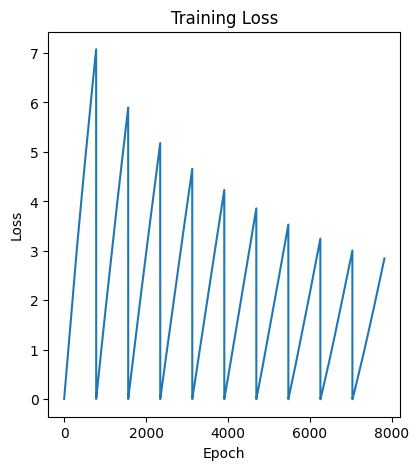

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")


